In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from DataSplit import *
from PCA import *
from RMSE import *

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
plt.style.use('default')
font1 ={'family': 'times', 'weight':'light', 'size': 9}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults, Savefig):
# 画出原始图
    Company_names = ['XZ', 'XJ', 'HLJ']
    k = np.array([0, 41, 83])
    j= 0
    # j, k1 = 0, 6
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)

    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015', '2016'], fontsize='small')
    ax.set_yticklabels(['0', '0','1', '2', '3', '4'], fontsize='small')
    ax.set_xlabel("Time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\Yuanshi1.png', dpi = 300, bbox_inches='tight')
    plt.show()
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7, 14, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)

    label_f1 = "Suspicious contaminant"
    ax.text(5.1,1.4,label_f1,fontsize=9,verticalalignment="top",horizontalalignment="right")
    ax.annotate('',xy=(1.1,1.53),xytext=(1.8,1.4),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
    
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015', '2016'], fontsize='small')
    ax.set_yticklabels(['0', '0','0.25', '0.50', '0.75', '1.00', '1.25', '1.50', '1.75'], fontsize='small')
    ax.set_xlabel("Time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[1]], loc='upper right', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\Yuanshi2.png', dpi = 300, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(14, 21, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)

    label_f1 = "Suspicious contaminant"
    ax.text(6.2,4.2,label_f1,fontsize=9,verticalalignment="top",horizontalalignment="right")
    ax.annotate('',xy=(2.0, 5),xytext=(3.0,4.3),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015', '2016'], fontsize='small')
    ax.set_yticklabels(['0', '0','1', '2', '3', '4', '5'], fontsize='small')
    ax.set_xlabel("Time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[2]], loc='upper right', frameon=False, fontsize='small')
#     leg = plt.legend()
#     leg.get_frame().set_linewidth(0.0)
    
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\Yuanshi3.png', dpi = 300, bbox_inches='tight')
    plt.show()
    return 0

(147, 4)


D:\Softwares\Python\Python_Anaconda\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


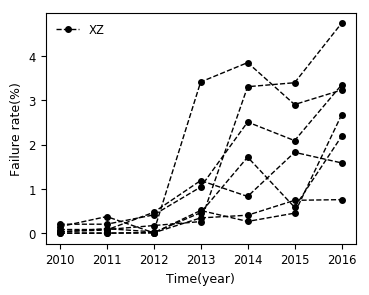

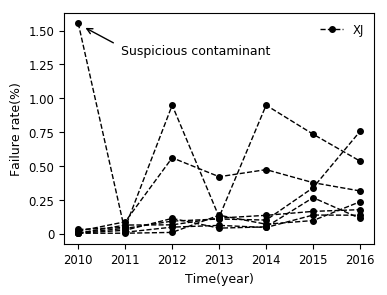

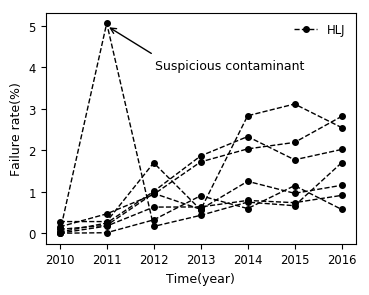

0

In [5]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 1 # 控制图形显示存储

elec_data = pd.read_csv('XZmulti_6_7Test.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])
SNR_Tem = np.random.normal(0, 1, size=[len(elec_data.Year.values), 1])
# #特征因素分析

elec_tem = elec_data.Tem.values + SNR_Tem[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
elec_year_Mean = (elec_year - np.mean(elec_year)) #均值化后的时间点

# print(data_cs_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
print(np.shape(elec_Pca))
# np.savetxt('elec_Pca.csv', elec_Pca, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
# elec_Pca_char1 = np.loadtxt('elec_Pca_char1.csv',delimiter = ',')
# elec_Pca_char2 = np.loadtxt('elec_Pca_char2.csv',delimiter = ',')

elec_data.Fault.values[56] =1200
elec_data.Fault.values[99] =700
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*7:(i+1)*7] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*7:(i+1)*7] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*7:(i+1)*7] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*7:(i+1)*7] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*7:(i+1)*7] for i in np.arange(21)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_Pca_char1))
xs_char2 = shared(np.asarray(elec_Pca_char2))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(elec_year))
Num_shared = shared(np.asarray(companyABC))
# 画图
Plot_XZ(elec_year2, elec_faults2, Savefig)


In [4]:
# 画出子模型集成收敛的图
Mean_Cumul_M2 = np.loadtxt('Mean_Cumul_M2.csv',delimiter = ',')
# print(Mean_Cumul_M2)
print(len(Mean_Cumul_M2))

# 对第7年预测值进行累加计算
PredMean_Cumul_M2 = []
for j in range(len(Mean_Cumul_M2)):
    MeanCumul_Value = []
    for i in range(len(Mean_Cumul_M2[0])):
        MeanCumul_Value.append(sum(Mean_Cumul_M2[j, jj] for jj in range(i+1))/(i+1) )
#         print(MeanCumul_Value)
    PredMean_Cumul_M2.append(MeanCumul_Value)
# print(PredMean_Cumul_M2)





# 计算拟合时的累计均方误差
# Mean_Train_M2_A为每次拟合时存储的6年数据值
# Mean_Train_M2_A1.csv为中间变量，需要删除的
Mean_Train_M2_A = np.loadtxt('Mean_Train_M2_A.csv',delimiter = ',')
Mean_Train_M2_B = np.loadtxt('Mean_Train_M2_B.csv',delimiter = ',')
Mean_Train_M2_C = np.loadtxt('Mean_Train_M2_C.csv',delimiter = ',')

print(Mean_Train_M2_A[0])
MeanTrain_Cumul_M2 = np.vstack((Mean_Train_M2_A, Mean_Train_M2_B, Mean_Train_M2_C))
# print(MeanTrain_Cumul_M2)
print(len(MeanTrain_Cumul_M2))
LenTrain_M2 = int(len(MeanTrain_Cumul_M2)/3) #总长度除以3，每省的训练数据长度
print(LenTrain_M2)

# 对拟合进行累加计算
TrainMeanCumul_ValueA =[]
TrainMeanCumul_ValueB =[]
TrainMeanCumul_ValueC =[]
for j in range(3):#3个省数据总长度
    A = MeanTrain_Cumul_M2[(j*LenTrain_M2):((j+1)*LenTrain_M2), ]
    for i in range(LenTrain_M2):        #每个省数据总长度
        if j==0:
            TrainMeanCumul_ValueA.append(sum(A[jj] for jj in range(i+1))/(i+1) )
        if j==1:
            TrainMeanCumul_ValueB.append(sum(A[jj] for jj in range(i+1))/(i+1) )
        if j==2:
            TrainMeanCumul_ValueC.append(sum(A[jj] for jj in range(i+1))/(i+1) )
# print(TrainMeanCumul_ValueC)
print(np.shape(TrainMeanCumul_ValueA))

3
[0. 0. 0. 1. 2. 3.]
184
61
(61, 6)


Rmse Mean is A、B、C :
Rmse Mean is A、B、C :
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:\Softwares\Python\Python_Anaconda\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


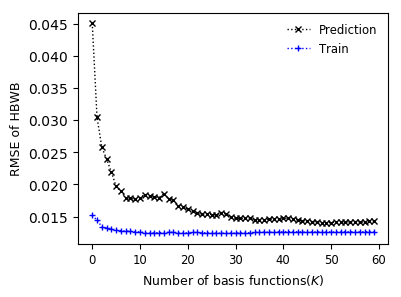

0.014065825925482315
0.002290276578933252
0.007079249252668755


In [6]:
# 计算预测的累计均方误差
# 读取第7年的实际数据
Pred_Data = pd.read_csv('XZmulti_6_Only7Test.csv')
Pred_faults = 100 * (Pred_Data.Fault.values / Pred_Data.Nums.values)  # 数组形式,计算故障率大小


def Rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

def RMSEfor_Pred1(Faults, FitValue, Len_One=7, Zoom_factor=100):
    Len_Faults = np.shape(Faults)
    Len_Fault = round(Len_Faults[0] / Len_One)  # round取整数，Len_Fault = 21/7 = 3

    Faults = Faults / Zoom_factor  # 还原数据
    FitValue = np.array(FitValue)
#     print(FitValue)
    FitValue = FitValue / Zoom_factor  # 还原数据
#     Faults_Col为 3*7的数组，3行7列
    Faults_Col = np.array([Faults[i * Len_One:(i + 1) * Len_One] for i in np.arange(Len_Fault)])  # 将输入数据排列好
#     FitValue为3行,未知长度
    Mean_Rmse = []
    for i in np.arange(3):
        Rmse_Value = []
        for jj in np.arange(len(FitValue[0])):
            A = Rmse(Faults_Col[i], FitValue[i, jj])  # 计算每组的均方根误差
            Rmse_Value = np.append(Rmse_Value, A)  # 计算每组的均方根误差
        # print(Rmse_Value)
        Mean_Rmse.append(Rmse_Value)   # 计算每省的均方根误差
    # print(Mean_Rmse)
    print('Rmse Mean is A、B、C :')
    return Mean_Rmse



# 输入Faults：原始数据单维
# FitValueA：A省累计训练数组，2维度
def RMSEfor_Train(Faults, FitValueA, FitValueB, FitValueC, Len_One=6, Zoom_factor=100):
    Len_Faults = np.shape(Faults)
    Len_Fault = round(Len_Faults[0] / Len_One)  # round取整数，Len_Fault = 21/7 = 3

    Faults = Faults / Zoom_factor  # 还原数据
    FitValueA = np.array(FitValueA)
    FitValueA = FitValueA / Zoom_factor  # 还原数据
    FitValueB = np.array(FitValueB)
    FitValueB = FitValueB / Zoom_factor  # 还原数据
    FitValueC = np.array(FitValueC)
    FitValueC = FitValueC / Zoom_factor  # 还原数据
    #     Faults_Col为 3*7的数组，3行21列
    Faults_Col = np.array([Faults[i * Len_One:(i + 1) * Len_One] for i in np.arange(Len_Fault)])  # 将输入数据排列好
#     print(Faults_Col)
    Mean_RmseA = []
    for jj in np.arange(len(FitValueA)):
        Rmse_Value = []
        for i in np.arange(7):
            A = Rmse(Faults_Col[i], FitValueA[jj])  # 计算每组的均方根误差
            Rmse_Value = np.append(Rmse_Value, A)  # 计算每组的均方根误差
            # print(Rmse_Value)
        Mean_RmseA.append(Rmse_Value.mean(axis=0))   # 计算每省的均方根误差
#     print(Mean_RmseA)
    
    Mean_RmseB = []
    for jj in np.arange(len(FitValueB)):
        Rmse_Value = []
        for i in np.arange(7):
            A = Rmse(Faults_Col[i+7], FitValueB[jj])  # 计算每组的均方根误差
            Rmse_Value = np.append(Rmse_Value, A)  # 计算每组的均方根误差
#             print(Rmse_Value)
        Mean_RmseB.append(Rmse_Value.mean(axis=0))   # 计算每省的均方根误差
#     print(Mean_RmseB)
    
    Mean_RmseC = []
    for jj in np.arange(len(FitValueC)):
        Rmse_Value = []
        for i in np.arange(7):
            A = Rmse(Faults_Col[i+14], FitValueC[jj])  # 计算每组的均方根误差
            Rmse_Value = np.append(Rmse_Value, A)  # 计算每组的均方根误差
#             print(Rmse_Value)
        Mean_RmseC.append(Rmse_Value.mean(axis=0))   # 计算每省的均方根误差
#     print(Mean_RmseC)
    MeanTrain_Out_M2 = np.vstack((Mean_RmseA, Mean_RmseB, Mean_RmseC))
#     print(MeanTrain_Out_M2)
    print('Rmse Mean is A、B、C :')
    return MeanTrain_Out_M2




# 计算预测第7年的累计均方误差
MseMeanPred_all = RMSEfor_Pred1(Pred_faults, PredMean_Cumul_M2)
MseMeanPred_all = MseMeanPred_all
# print(MseMeanPred_all)
# np.savetxt('MseMeanPred_all.csv', MseMeanPred_all, delimiter = ',')

# 计算6年拟合值的累计误差
Train_Output_M2 = RMSEfor_Train(elec_faults, TrainMeanCumul_ValueA, TrainMeanCumul_ValueB, TrainMeanCumul_ValueC)
print(Train_Output_M2)
Train_Output_M2 = Train_Output_M2

# # 计算预测第7年的累计均方误差
# fig = plt.figure(figsize=(4, 3))
# ax = plt.subplot(1, 1, 1)

xl = np.arange(60)
# ax.plot(xl, MseMeanPred_all[0], 'k+-', color='y')
# ax.plot(xl, MseMeanPred_all[1], 'k+-', color='r')
# ax.plot(xl, MseMeanPred_all[2], 'b+-', color='b')
# plt.show()

# # 计算6年拟合值的累计误差
# fig = plt.figure(figsize=(4, 3))
# ax = plt.subplot(1, 1, 1)
x2 = np.arange(60)

# ax.plot(x2, Train_Output_M2[0], 'k:+', color='y')
# ax.plot(x2, Train_Output_M2[1], 'k:+', color='r')
# ax.plot(x2, Train_Output_M2[2], 'k:+', color='b')
# plt.show()


font2 = {'family':'Times', 'weight':'normal', 'size': 9}  
# 计算6年拟合值的累计误差
fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)

ax1, = ax.plot(xl, MseMeanPred_all[0][:60], 'k:x', color='k', markersize=4, linewidth=1)
ax2, =ax.plot(x2, Train_Output_M2[0][:60], 'k:+', color='b', markersize=4, linewidth=1)
ax.set_xticklabels([ '60', '0','10', '20', '30', '40', '50', '60'], fontsize='small')
# plt.axis([-0.5, 60, -.1, 1.6])
plt.xlabel("Number of basis functions($K$)", fontdict=font2)
plt.ylabel("RMSE of HBWB", fontdict=font2)
plt.legend([ax1, ax2], ['Prediction', 'Train'], loc='upper right', frameon=False, fontsize='small')

plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\RMSE1.png', dpi = 600, bbox_inches='tight')
plt.show()
aaa = MseMeanPred_all[0]
bbb = MseMeanPred_all[1]
ccc = MseMeanPred_all[2]
print(aaa[-1]);print(bbb[-1]);print(ccc[-1])

In [9]:
# 读取第7年的实际数据
Pred_Data = pd.read_csv('XZmulti_6_Only7Test.csv')
Pred_faults = 100 * (Pred_Data.Fault.values / Pred_Data.Nums.values)  # 数组形式,计算故障率大小
Pred_faults2 = np.array([Pred_faults[i * 7:(i + 1) * 7] for i in np.arange(3)])
print(Pred_faults2)
#拟合子模型结果
Mean_output = np.loadtxt('Mean_output.csv',delimiter = ',')
M0_Mean_output = np.loadtxt('M0_Mean_output.csv',delimiter = ',')
# print(Mean_output)

#预测模型结果
# M2_Pred_yplot_Mean_C = np.loadtxt('M2_Pred_yplot_Mean_C.csv',delimiter = ',')
M3_Pred_yplot_Mean_C = np.loadtxt('M3_Pred_yplot_Mean_C.csv',delimiter = ',')
M4_Pred_yplot_Mean_C = np.loadtxt('M4_Pred_yplot_Mean_C.csv',delimiter = ',')

#对比模型结果
Y_PLSpred_MEAN = np.loadtxt('Y_PLSpred_MEAN.csv',delimiter = ',')
Y_SVMpred = np.loadtxt('Y_SVMpred.csv',delimiter = ',')
# print(Y_SVMpred)

[[2. 3. 3. 1. 2. 5. 3.]
 [0. 0. 0. 0. 1. 1. 0.]
 [2. 1. 1. 2. 1. 3. 3.]]


D:\Softwares\Python\Python_Anaconda\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


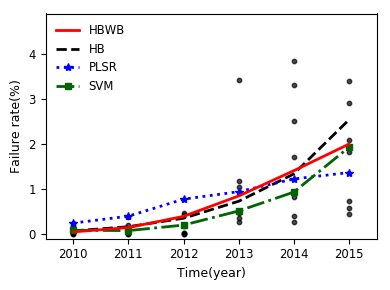

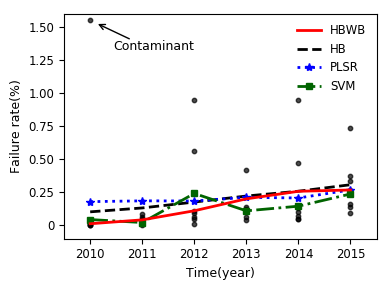

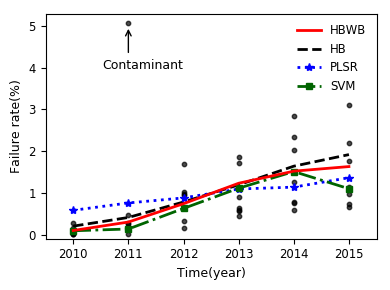

In [37]:
fig = plt.figure(figsize=(4, 3))
font1 ={'family': 'Times', 'weight':'normal', 'size': 9}  

ip=0
# for ip in np.arange(companiesABC):
ax = plt.subplot(1, 1, 1)
xp = elec_year2[ip*7:(ip+1)*7, :]
yp = elec_faults2[ip*7:(ip+1)*7, :]
xl = [1,2,3,4,5,6]
x2 = [7,7,7,7,7,7,7]

y1 = Mean_output[ip]
y2 = M0_Mean_output[ip]
y3 = Y_PLSpred_MEAN[ip]
y4 = Y_SVMpred[ip]

# plt.scatter(x2, Pred_faults2[0], marker='o', alpha=0.6, c='k',s=10, linewidths=1)
plt.scatter(xp, yp, marker='o', alpha=0.7, c='k',s=10, linewidths=1)
ax2, = plt.plot(xl, y2,  'k--', linewidth=2)
ax3, = plt.plot(xl, y3, '*:', color='b', linewidth=2)
ax4, = plt.plot(xl, y4, 's-.', color='#006400', markersize=4, linewidth=2)
ax1, = plt.plot(xl, y1, 'r', linewidth=2)

plt.axis([0.5, 6.5, -.1, 4.9])
plt.xlabel("Time(year)", fontdict=font1)
plt.ylabel("Failure rate(%)", fontdict=font1)
plt.legend([ax1, ax2, ax3, ax4], ['HBWB', 'HB','PLSR','SVM'], loc='upper left', frameon=False, fontsize='small')
ax.set_xticklabels(['2010','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
ax.set_yticklabels(['0', '0','1', '2', '3', '4'], fontsize='small')
Savefig = 0
plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\CompareA.png', dpi = 300, bbox_inches='tight')
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\HBWB1.svg', format='svg')
    
plt.tight_layout()
plt.show()




fig = plt.figure(figsize=(4, 3))
ip=1
# for ip in np.arange(companiesABC):
ax = plt.subplot(1, 1, 1)
xp = elec_year2[ip*7:(ip+1)*7, :]
yp = elec_faults2[ip*7:(ip+1)*7, :]
xl = [1,2,3,4,5,6]

y1 = Mean_output[ip]
y2 = M0_Mean_output[ip]
y3 = Y_PLSpred_MEAN[ip]
y4 = Y_SVMpred[ip]

# plt.scatter(x2, Pred_faults2[1], marker='o', alpha=0.6, c='k',s=10, linewidths=1)
plt.scatter(xp, yp, marker='o', alpha=0.7, c='k',s=10, linewidths=1)
ax2, = plt.plot(xl, y2,  'k--', linewidth=2)
ax3, = plt.plot(xl, y3, '*:', color='b', linewidth=2)
ax4, = plt.plot(xl, y4, 's-.', color='#006400', markersize=4, linewidth=2)
ax1, = plt.plot(xl, y1, 'r', linewidth=2)

plt.axis([0.5, 6.5, -.1, 1.6])
plt.xlabel("Time(year)", fontdict=font1)
plt.ylabel("Failure rate(%)", fontdict=font1)
plt.legend([ax1, ax2, ax3, ax4], ['HBWB', 'HB','PLSR','SVM'], loc='upper right', frameon=False, fontsize='small')
label_f1 = "Contaminant"
ax.text(3.0,1.4,label_f1,fontsize=9,verticalalignment="top",horizontalalignment="right")
ax.annotate('',xy=(1.1,1.53),xytext=(1.8,1.4),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))

ax.set_xticklabels(['2010','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
ax.set_yticklabels(['0', '0','0.25', '0.50', '0.75', '1.00', '1.25', '1.50', '1.75'], fontsize='small')

plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\CompareB.png', dpi = 300, bbox_inches='tight')
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\HBWB2.svg', format='svg')
    
plt.tight_layout()
plt.show()





fig = plt.figure(figsize=(4, 3))
ip=2
# for ip in np.arange(companiesABC):
ax = plt.subplot(1, 1, 1)
xp = elec_year2[ip*7:(ip+1)*7, :]
yp = elec_faults2[ip*7:(ip+1)*7, :]
xl = [1,2,3,4,5,6]

y1 = Mean_output[ip]
y2 = M0_Mean_output[ip]
y3 = Y_PLSpred_MEAN[ip]
y4 = Y_SVMpred[ip]

# plt.scatter(x2, Pred_faults2[2], marker='o', alpha=0.6, c='k',s=10, linewidths=1)
plt.scatter(xp, yp, marker='o', alpha=0.7, c='k',s=10, linewidths=1)
ax2, = plt.plot(xl, y2,  'k--', linewidth=2)
ax3, = plt.plot(xl, y3, '*:', color='b', linewidth=2)
ax4, = plt.plot(xl, y4, 's-.', color='#006400', markersize=4, linewidth=2)
ax1, = plt.plot(xl, y1, 'r', linewidth=2)

plt.axis([0.5,6.5, -.1, 5.3])
plt.xlabel("Time(year)", fontdict=font1)
plt.ylabel("Failure rate(%)", fontdict=font1)
plt.legend([ax1, ax2, ax3, ax4], ['HBWB', 'HB','PLSR','SVM'], loc='upper right', frameon=False, fontsize='small')
label_f1 = "Contaminant"
ax.text(3.0,4.2,label_f1,fontsize=9,verticalalignment="top",horizontalalignment="right")
ax.annotate('',xy=(2.0, 5),xytext=(2.0,4.3),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))

ax.set_xticklabels(['2010','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
ax.set_yticklabels(['0', '0','1', '2', '3', '4', '5'], fontsize='small')
# ax.set_yticklabels(fontsize='small')

plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\CompareC.png', dpi = 300, bbox_inches='tight')
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\HBWB3.svg', format='svg')
    
plt.tight_layout()
plt.show()

D:\Softwares\Python\Python_Anaconda\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


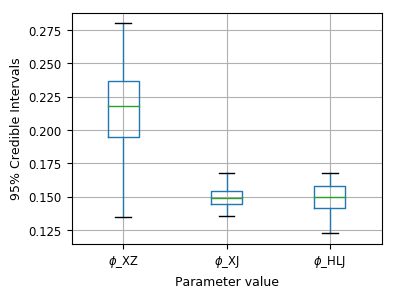

In [36]:
import pandas as pd  
def list_generator(mean,dis,number):#封装一下这个函数，用来后面生成数据  
    return np.random.normal(mean,dis*dis,number)#normal分布，输入的参数是均值、标准差以及生成的数量  
#我们生成四组数据用来做实验，我们都只生成100个数据  
list1=list_generator(0.2175,0.1698,100)  
list2=list_generator(0.1493,0.0787,100)  
list3=list_generator(0.1494,0.1033,100)  
#把四个list导入到pandas的数据结构中，dataframe  
data = pd.DataFrame({   "$ϕ$_XZ":list3, "$ϕ$_XJ":list2, "$ϕ$_HLJ":list1 })
fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
data.boxplot()#这里，pandas自己有处理的过程，很方便哦。  
plt.ylabel("95% Credible Intervals", fontdict=font2) 
plt.xlabel("Parameter value", fontdict=font2)#我们设置横纵坐标的标题。
ax.set_xticklabels(['$ϕ$_XZ','$ϕ$_XJ', '$ϕ$_HLJ'], fontsize='small')
ax.set_yticklabels(['0', '0.125','0.150', '0.175', '0.200', '0.225', '0.250', '0.275', '0.300'], fontsize='small')
plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\Phij.png', dpi = 300, bbox_inches='tight')
plt.show() 

D:\Softwares\Python\Python_Anaconda\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


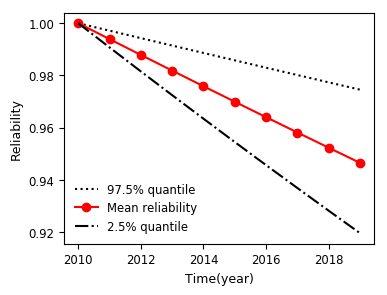

In [33]:
t = np.arange(0, 10, 1)
fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
R11 = np.loadtxt('R11.csv',delimiter = ',')
R22 = np.loadtxt('R22.csv',delimiter = ',')
R33 = np.loadtxt('R33.csv',delimiter = ',')
plt.plot(t, R22, 'k:', t, R11, 'ro-', t, R33, 'k-.')
ax.set_xticklabels(['2016', '2010', '2012', '2014', '2016', '2018', '2015', '2016', '2017'], fontsize='small')
ax.set_yticklabels(['0', '0.92','0.94', '0.96', '0.98', '1.00'], fontsize='small')
ax.set_xlabel("Time(year)", fontdict=font2)
plt.ylabel("Reliability", fontdict=font2)
# plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
ax.legend(['97.5% quantile','Mean reliability','2.5% quantile'], loc='lower left',frameon=False, fontsize='small')

plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\Reliability.png', dpi = 300, bbox_inches='tight')
plt.show()

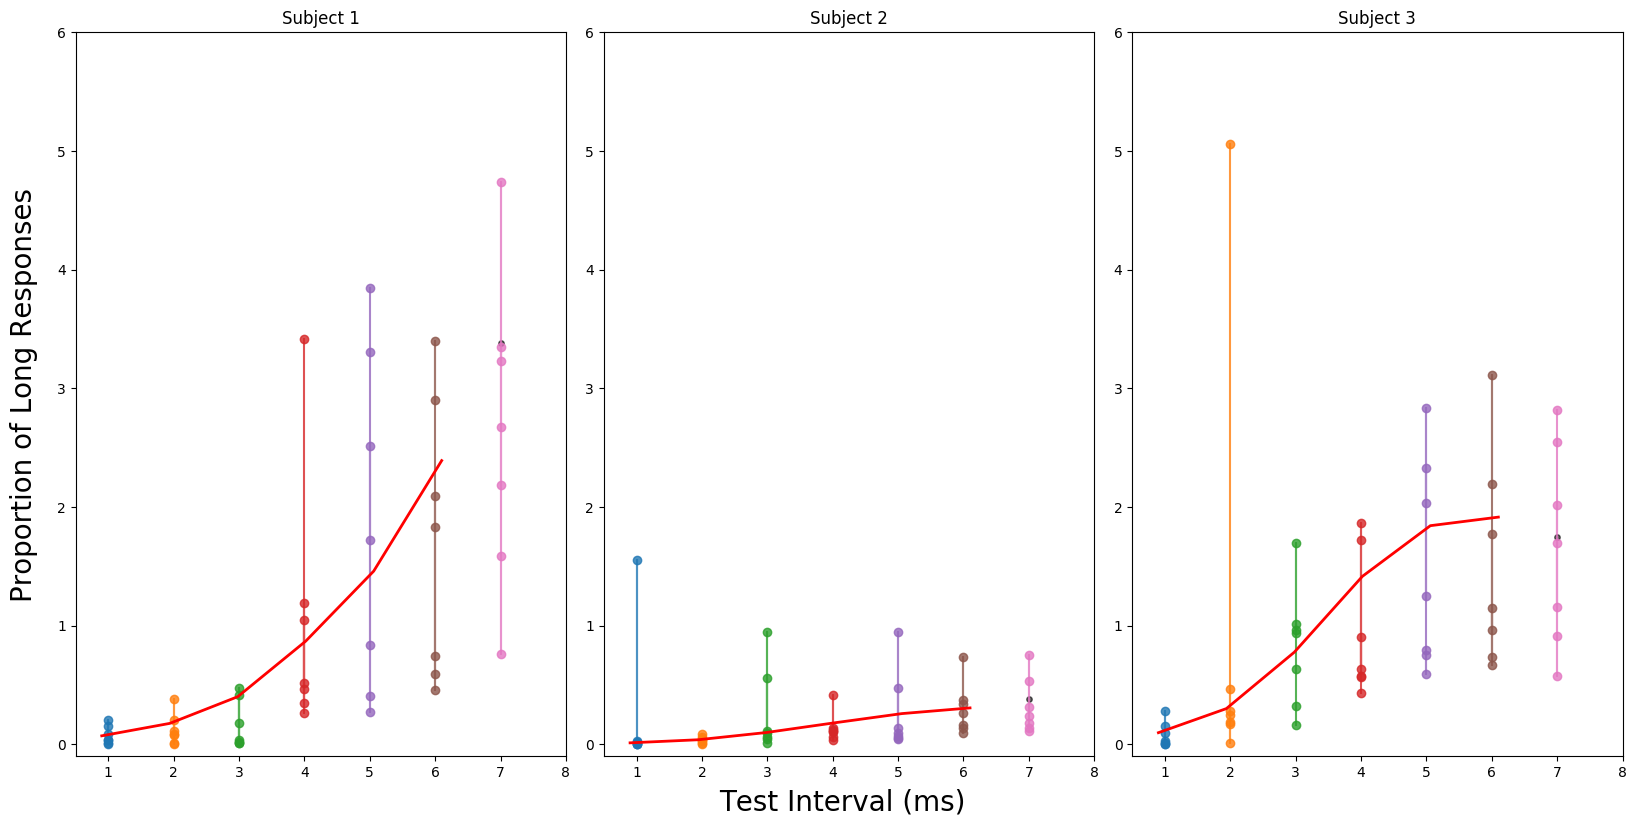

In [11]:
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)

PredMean_Cumul_M2 = np.array(PredMean_Cumul_M2)
for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    
    x2 = 7
    xl = np.linspace(0.9, 6.1, 6)
    if ip==0:
        y2 = TrainMeanCumul_ValueA[-1]
        y3 = PredMean_Cumul_M2[0, -1]
    if ip==1:
        y2 = TrainMeanCumul_ValueB[-1]
        y3 = PredMean_Cumul_M2[1, -1]
    if ip==2:
        y2 = TrainMeanCumul_ValueC[-1]
        y3 = PredMean_Cumul_M2[2, -1]

    #     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
    #     plt.plot(xl, yl, 'k--', linewidth=2)
    plt.plot(xl, y2,  'r', linewidth=2)
    plt.scatter(x2, y3, marker='o', alpha=0.6, c='k',s=15, linewidths=1)
    plt.axis([0.5, 8, -.1, 6])
    plt.title('Subject %s' % (ip + 1))

    plt.tight_layout()
plt.show()